#Introduction

Every summer, the wonderful folks at Night Attack host what they call "The Summer Movie Draft." The rules of the draft are simple, players have 100 "units" to spend on purchasing various movies in an auction style event. Parties then compete to buy the most lucrative movies, defined by the total gross that they will make.

#Data Aggregation

##Players
You can watch the auction [here](http://nightattack.tv/episode/58) but for the sake of this notebook, i've compiled the data as follows. You should still watch the episode as it is great fun. We want to have the data in a nice accessable way so the structure is as follows

* Dictionary where keys = players, values = info list for the players
    * info list contains a list movies purchased, and total gross amount
        * list of movies purchased contains lists with movie purchased information
            * every movie purchased info item contains the Movie ID, Purchased for ammount, and resulting gross

In [2]:
players = { "GFQ":          [[["fast7",37,0], ["paulblart2",16,0], ["entourage",10,0], ["max2015",5,0], ["magicmike2",18,0], ["papertowns",14,0]],0],
            "Amtrekker":    [[["avengers2",80,0], ["insidiouschapter3",8,0], ["susancooper",12,0]],0],
            "Frogpants":    [[["cybernatural",13,0], ["furyroad",22,0], ["pitchperfect2",18,0], ["poltergeist2015",15,0], ["terminator2015",19,0], ["Pixels",9,0]],0],
            "Night Attack": [[["witherspoonvergara",11,0], ["1952",26,0], ["crowe2014",10,0], ["pixar2014",36,0], ["trainwreck15",17,0]],0],
            "Cordkillers":  [[["thelongestride",10,0], ["jurassicpark4",42,0], ["minions",42,0]],0],
            "DTNS":         [[["sanandreas",16,0], ["ted2",18,0], ["selfless",6,0], ["antman",18,0], ["newline15",9,0], ["mi5",7,0], ["fantasticfour15",8,0]], 0]
          }


We now have a dictionary of the teams, followed by a list containing the movies they have purchased as well as the corresponding values.

In [3]:
players["Night Attack"][0]

[['witherspoonvergara', 11, 0],
 ['1952', 26, 0],
 ['crowe2014', 10, 0],
 ['pixar2014', 36, 0],
 ['trainwreck15', 17, 0]]

Each entry in the list contains the following information: The movie "ID", the purchase ammount of the movie, how much that movie has made (we'll populate that later)

The movie ID's come from [Box Office Mojo's website](www.boxofficemojo.com) which we will use later to retrieve new data. But those ID's aren't always the most descriptive. For example "witherspoonvergara" only tells me the two main actors in the film, and not what movie it is.

We can make another dictionary that will just use the ID's as Keys and the associated values will be their Show Title.

In [4]:
movieName={ 
            "fast7":"Furious 7",
            "paulblart2": "Paul Blart: Mall Cop 2",
            "entourage":"Entourage",
            "max2015":"Max",
            "magicmike2":"Magic Mike XXL",
            "papertowns":"Paper Towns",
            "avengers2":"Avengers: Age of Ultron",
            "insidiouschapter3":"Insidious Chapter 3",
            "susancooper":"Spy",
            "cybernatural":"Unfriended",
            "furyroad":"Mad Max: Fury Road",
            "pitchperfect2":"Pitch Perfect 2",
            "poltergeist2015":"Poltergeist",
            "terminator2015":"Terminator: Genisys",
            "Pixels":"Pixels",
            "witherspoonvergara":"Hot Pursuit",
            "1952":"Tomorrowland",
            "crowe2014":"Aloha",
            "pixar2014":"Inside Out",
            "trainwreck15":"Trainwreck",
            "thelongestride":"The Longest Ride",
            "jurassicpark4":"Jurassic World",
            "minions":"Minions",
            "sanandreas":"San Andreas",
            "ted2":"Ted 2",
            "selfless":"Self/Less",
            "antman":"Ant-Man",
            "newline15":"Vacation",
            "mi5":"Mission: Impossible - Rogue Nation",
            "fantasticfour15":"Fantastic Four"
          }

In [5]:
print("Movie ID:   " + players["Night Attack"][0][0][0])
print("Show Title: " + movieName[players["Night Attack"][0][0][0]])

Movie ID:   witherspoonvergara
Show Title: Hot Pursuit


So now we have a nice, easy, reliable way to figure out who the players are and what will be their playing cards

##Data Scraping

Now that we have all our data setup, we want to get the useful data from somewhere. To do this, we will use python's Request and RegEx libraries. 

Before you tell me that parsing HTML with RegEx is bad, [I am aware.](http://stackoverflow.com/questions/1732348/regex-match-open-tags-except-xhtml-self-contained-tags).

Luckily for us, Box Office Mojo is a wonderful resource which we'll use to gather information about grossing totals. To do this, we'll use their script for widgets that display grossing totals of movies.

Let's look at what that site will look like. [Here's what it looks like for Furious 7](http://www.boxofficemojo.com/data/js/moviegross.php?id=fast7.htm)

So let's grab those values with the request library.

In [6]:
import requests

BASE_URL = "http://www.boxofficemojo.com/data/js/moviegross.php?id="
response = requests.get(BASE_URL + "fast7" + ".htm")
print(response.text)

document.write('<style type="text/css"><!-- td.mojo_copyright { text-align: center; background-color: #000000; font-size: 7pt; font-family: arial; } a.mojocopyra:link, a.mojocopyra:visited, a.mojocopyra:active { color: #ffffff; font-size: 7pt; font-family: arial; } a.mojocopyra:hover { color: #ffffff; font-size: 7pt; font-family: arial; text-decoration: underline; background: none } ');

	document.write('td.mojo_header { text-align: center; background-color: #8b0000; font-size: 9pt; font-family: verdana; font-weight: bold; color: #ffffff } ');

	document.write('td.mojo_row { background-color: #ffffff; font-size: 9pt; font-family: verdana; color: #000000 } ');

document.write('--></style>');
document.write('<table border=0 cellspacing=1 cellpadding=3>');
document.write('<tr><td align=center class=mojo_header>Furious 7</td></tr>');
document.write('<tr><td align=center class=mojo_row><b>$350,783,000</b><br>as of 6/14/15</td></tr>');
document.write('<tr><td class=mojo_copyright><a class=mo

So boxofficemojo creates a little widget which always follow a certain pattern (theoretically you could call this a regular language as per Chomsky's Heirarchy).

We can now use Regular Expressions to grab the information we actually care about, the gross value. We know that the money is going to be presented as a dollar sign, followed by a money amount, surrounded by a string. so lets look exactly for that.

In [7]:
import re
gross = re.findall(r'<b>\$(.*)<\/b>',response.text)
print(gross)

[u'350,783,000']


Check that out! We just got that gross value, but it's still a string. so lets clean it up. We need to get rid of those commas so we can convert it to an int.

In [8]:
moneyMade = int("".join(gross[0].split(',')))
print(moneyMade)

350783000


Now that we know how to get the data for one movie. Lets play it out in the big picture and get it working for all of our movies and players

In [9]:
for player, info in players.iteritems():
    playerTotal = 0
    for m_iter,movie in enumerate(info[0]):
        response = requests.get(BASE_URL+ movie[0] + ".htm") #the .htm is necessary for boxofficemojo
        gross = re.findall(r'<b>\$(.*)<\/b>',response.text)
        if gross:
            moneyMade = int("".join(gross[0].split(',')))
            players[player][0][m_iter][2] = moneyMade 
            playerTotal+=moneyMade
    players[player][1] = playerTotal

Now there's a lot of things going on there but let's disect it line by line.

    for player, info in players.iteritems():
Here we're getting iter items which takes the players dictionary and splits it into its keys and values. We then assign the pair to player, and info.

    playerTotal = 0
We're just going to create a temporary variable to hold how much money each player has made

    for m_iter,movie in enumerate(info[0]):
So now for every block of movie info (name, purchase amount, gross amount) we're going to enumerate it, which means we'll get two pieces of information. movie will hold that list of information, m_iter will hold the index of that list with regard to the larger list surrounding it.

    response = requests.get(BASE_URL+ movie[0] + ".htm")
This is that request code that we setup earlier which will grab the webpage from  boxoffice mojo

    gross = re.findall(r'<b>\$(.*)<\/b>',response.text)
This is the RegEx code which will then grab that nice grossing value

    if gross:
This code checks to make sure that there was a match for the RegEx. If there wasn't (for example, if the movie hasn't been released yet) then gross will not exist, so we don't need to do anything.

    moneyMade = int("".join(gross[0].split(',')))
Converting that String into a nice numerical value

    players[player][0][m_iter][2] = moneyMade 
Now this takes that big players database, goes to the specific player, goes to their list of movies, goes to that specific movie, and changes the third record for the specific movie to be the amount made for that movie

    playerTotal+=moneyMade
This is a bit hacky and technically could be done cleaner but might as well update it while we're accessing it so we don't have to do extra work later

    players[player][1] = playerTotal
And lets update that player total for each player

Now we got all of that out of the way, let's see what data we have now.

In [10]:
players["Night Attack"]

[[['witherspoonvergara', 11, 33568175],
  ['1952', 26, 83607000],
  ['crowe2014', 10, 18960000],
  ['pixar2014', 36, 0],
  ['trainwreck15', 17, 0]],
 136135175]

Sweet! We now have that third field populated and we can now do some analytics

##Analytics

Now let's get to some fun stuff. We could do some simple analytics like this

In [11]:
for player,info in players.iteritems():
    print(player + " has made " + str(info[1]))

Cordkillers has made 241886339
DTNS has made 119321000
GFQ has made 445956000
Frogpants has made 387914090
Amtrekker has made 539051000
Night Attack has made 136135175


Yeah, that's not interesting. What if we try something more.

In [12]:
for player,info in players.iteritems():
    print(player + " has made " + str(info[1]))
    for movie in info[0]:
        print ("-->"+movieName[movie[0]]+" has generated/paid "+str(movie[2])+"/"+str(movie[1]))

Cordkillers has made 241886339
-->The Longest Ride has generated/paid 37286339/10
-->Jurassic World has generated/paid 204600000/42
-->Minions has generated/paid 0/42
DTNS has made 119321000
-->San Andreas has generated/paid 119321000/16
-->Ted 2 has generated/paid 0/18
-->Self/Less has generated/paid 0/6
-->Ant-Man has generated/paid 0/18
-->Vacation has generated/paid 0/9
-->Mission: Impossible - Rogue Nation has generated/paid 0/7
-->Fantastic Four has generated/paid 0/8
GFQ has made 445956000
-->Furious 7 has generated/paid 350783000/37
-->Paul Blart: Mall Cop 2 has generated/paid 69303000/16
-->Entourage has generated/paid 25870000/10
-->Max has generated/paid 0/5
-->Magic Mike XXL has generated/paid 0/18
-->Paper Towns has generated/paid 0/14
Frogpants has made 387914090
-->Unfriended has generated/paid 32482090/13
-->Mad Max: Fury Road has generated/paid 138608000/22
-->Pitch Perfect 2 has generated/paid 170715000/18
-->Poltergeist has generated/paid 46109000/15
-->Terminator: G

Ehhh, that's all plain text. Let's get some visuals. What would be interesting things to see. Well let's keep it simple, how about lets see where everyone lays out on the map with their totals.

To do this, we'll use matplotlib

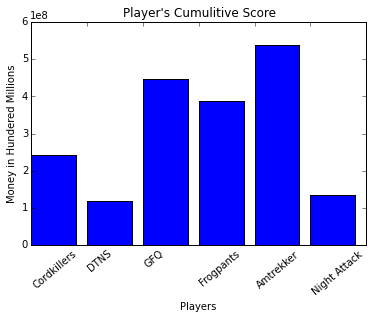

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

playersTotals = [info[1] for player,info in players.iteritems()]

rectangles = ax.bar(range(len(players.keys())),playersTotals,.8)
ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Players")
ax.set_xticklabels(players.keys(),rotation=40,ha='left')
plt.title("Player's Cumulitive Score")
plt.show()

Check that out! That's nice. But man, that's still a bit boring, kinda like that standard Microsoft Office generated stuff. Let's keep going.

What's the relationship between how much the players paid for the movie and how much they got from it?

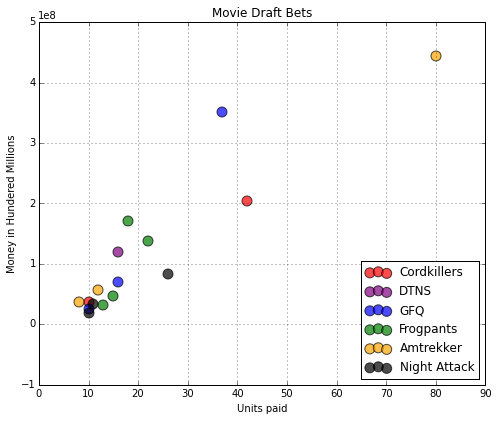

In [14]:
fig,ax = plt.subplots(figsize=(8,6.5))


colors={
        "Cordkillers":"red",
        "DTNS":"purple",
        "GFQ":"blue",
        "Frogpants":"green",
        "Amtrekker":"orange",
        "Night Attack":"black"
        }
for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    labels = []
    for item in info[0]:
        labels.append(item[0])
        if(item[2] != 0):
            x_axis.append(item[1])
            y_axis.append(item[2])
    plt.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])

ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Units paid")
plt.title("Movie Draft Bets")
plt.grid(True)
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')
plt.show()

Look at that! Colors, and circles! And man that looks a heck of a lot more interesting than before. Let's see if we can get some more information, like clustering.

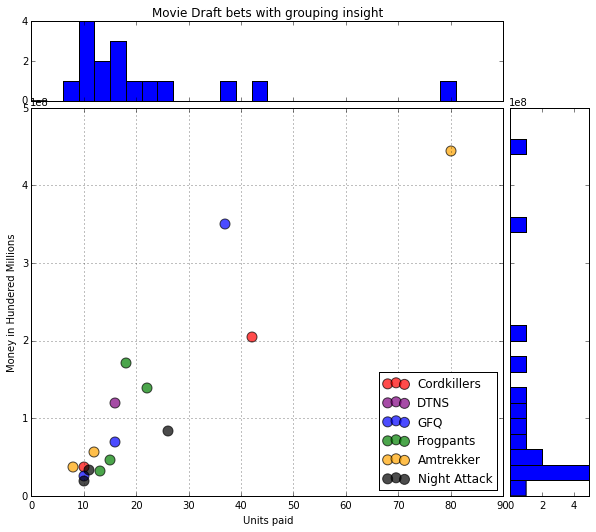

In [15]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax = plt.subplots(figsize=(10,8.5))

colors={
        "Cordkillers":"red",
        "DTNS":"purple",
        "GFQ":"blue",
        "Frogpants":"green",
        "Amtrekker":"orange",
        "Night Attack":"black"
        }

xmax = -1
ymax = -1

x_ = []
y_ = []
for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    for item in info[0]:
        if(item[2] != 0):
            
            x_axis.append(item[1])
            x_.append(item[1])
            y_axis.append(item[2])
            y_.append(item[2])
        
        if (item[1] > xmax): 
            xmax = item[1]
        
        if (item[2] > ymax): 
            ymax = item[2]
    ax.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])

leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')
plt.grid(True)
ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Units paid")


divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top",1.1,pad=0.1,sharex=ax)
plt.title("Movie Draft bets with grouping insight")
axHisty = divider.append_axes("right",1.1,pad=0.1,sharey=ax)

plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(), visible=False)

binwidth = 3
binwidth2= 20000000

lim = ( int(xmax/binwidth) + 1) * binwidth
lim2= ( int(ymax/binwidth2) + 1) * binwidth2

bins1 = np.arange(0, lim + binwidth, binwidth)
bins2 = np.arange(0, lim2 + binwidth2, binwidth2)

axHistx.hist(x_, bins=bins1)
axHisty.hist(y_, bins=bins2, orientation='horizontal')

axHistx.set_yticks([0, 2, 4])
axHisty.set_xticks([0, 2, 4])


plt.show()

So that's nice, that gives us a better idea of how thigns are clustered with the histograms. And we can see that in the right histogram , column, everything is sorta around the low balling areas with the exception of the big payers on top. And then on the top histogram, we see that pretty much, everyone paid in the less than 30 range with some overlab in the 10s. 

That's nice, but can we get some more context for each player and their highest grossing movie.

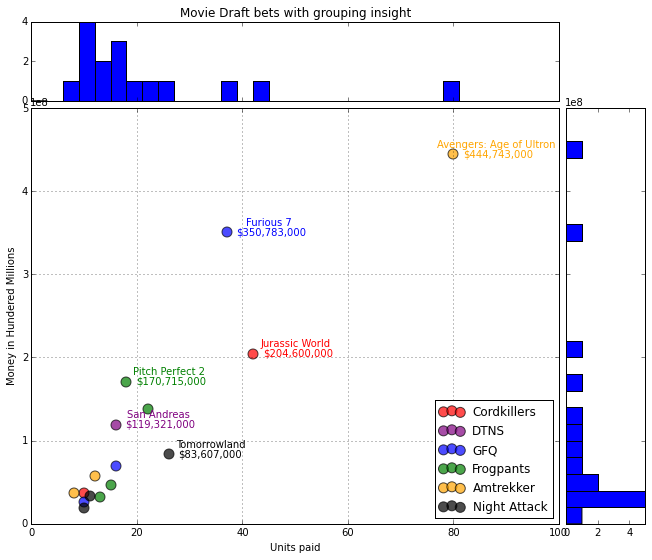

In [16]:
import locale
from mpl_toolkits.axes_grid1 import make_axes_locatable

locale.setlocale(locale.LC_ALL, '')

fig,ax = plt.subplots(figsize=(11,9))

colors={
        "Cordkillers":"red",
        "DTNS":"purple",
        "GFQ":"blue",
        "Frogpants":"green",
        "Amtrekker":"orange",
        "Night Attack":"black"
        }

xmax = -1
ymax = -1

x_ = []
y_ = []

bestGross = {
        "Cordkillers":[-1,-1,""],
        "DTNS":[-1,-1,""],
        "GFQ":[-1,-1,""],
        "Frogpants":[-1,-1,""],
        "Amtrekker":[-1,-1,""],
        "Night Attack":[-1,-1,""]
    }

for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    for item in info[0]:
        if(item[2] != 0):
            
            x_axis.append(item[1])
            x_.append(item[1])
            y_axis.append(item[2])
            y_.append(item[2])
        if item[2] > bestGross[player][1]:
            bestGross[player][1] = item[2]
            bestGross[player][0] = item[1]
            bestGross[player][2] = item[0]
            
        if (item[1] > xmax): 
            xmax = item[1]
        if (item[2] > ymax): 
            ymax = item[2]
    ax.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])


for player,info in bestGross.iteritems():
    ax.annotate(movieName[info[2]], (info[0]+8,info[1]+6000000),va="bottom", ha="center",color=colors[player])
    ax.annotate("$"+locale.format("%d", info[1], grouping=True), (info[0]+2,info[1]),va="center", ha="left",color=colors[player])
    
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')
plt.grid(True)
ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Units paid")


divider = make_axes_locatable(ax)
axHistx = divider.append_axes("top",1.1,pad=0.1,sharex=ax)
plt.title("Movie Draft bets with grouping insight")
axHisty = divider.append_axes("right",1.1,pad=0.1,sharey=ax)

plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(), visible=False)
binwidth = 3
binwidth2= 20000000

lim = 95
lim2= ( int(ymax/binwidth2) + 1) * binwidth2

bins1 = np.arange(0, lim + binwidth, binwidth)
bins2 = np.arange(0, lim2 + binwidth2, binwidth2)

axHistx.hist(x_, bins=bins1)
axHisty.hist(y_, bins=bins2, orientation='horizontal')
axHistx.set_yticks([0, 2, 4])
axHisty.set_xticks([0, 2, 4])


plt.show()

So that's pretty cool! We can see what those movies were and get a really good insight to what that movie made!

Let's see what each individual players looks like

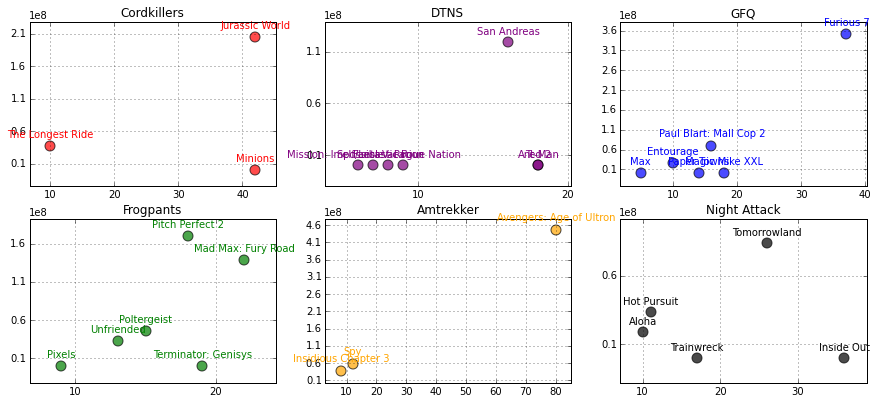

In [17]:
colors={
        "Cordkillers":"red",
        "DTNS":"purple",
        "GFQ":"blue",
        "Frogpants":"green",
        "Amtrekker":"orange",
        "Night Attack":"black"
        }
fig,ax = plt.subplots(figsize=(15,10))
t = 1
for player,info in players.iteritems():
    # Share a X axis with each column of subplots    
    plt.subplot(330+t)
    plt.title(player)
    plt.xticks(np.arange(0, 90, 10))
    plt.yticks(np.arange(10000000, 500000000, 50000000))
    t+=1
    x_axis = [movie[1] for movie in info[0]]
    y_axis = [movie[2] for movie in info[0]]
    labels = [movie[0] for movie in info[0]]
    plt.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])
    plt.grid(True)
    for money,paid,name in zip(y_axis,x_axis,labels):
        plt.annotate(movieName[name], (paid,money+(.05*max(y_axis))),va="bottom", ha="center",color=colors[player])

Well that's not too bad, and it definitely is a nice thing to see everyones movies presented visually, but lets see what were the big play makers this draft.

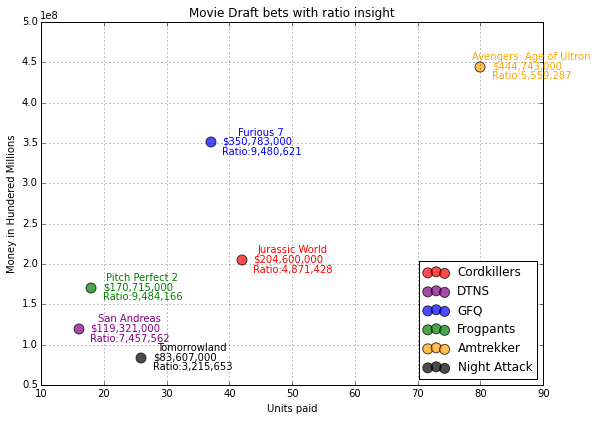

In [18]:
fig,ax = plt.subplots(figsize=(9,6.5))
for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    labels = []
    ratios = []
    for item in info[0]:
        labels.append(item[0])
        ratios.append(item[2]/item[1])
        x_axis.append(item[1])
        y_axis.append(item[2])
    BigWinner = ratios.index(max(ratios))
    
    plt.scatter(x_axis[BigWinner],y_axis[BigWinner],s=100,alpha=0.7,label=player,c=colors[player])
    plt.annotate(movieName[labels[BigWinner]], (x_axis[BigWinner]+8,y_axis[BigWinner]+6000000),va="bottom", ha="center",color=colors[player])
    plt.annotate("$"+locale.format("%d", y_axis[BigWinner], grouping=True), (x_axis[BigWinner]+2,y_axis[BigWinner]),va="center", ha="left",color=colors[player])
    plt.annotate("Ratio:"+locale.format("%d", ratios[BigWinner], grouping=True), (x_axis[BigWinner]+2,y_axis[BigWinner]-12000000),va="center", ha="left",color=colors[player])
        
ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Units paid")
plt.title("Movie Draft bets with ratio insight")
plt.grid(True)
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')
plt.show()

This is really nice as it shows us how the pay correlates with the output of the movie. It really gives a much different view of how you should purchase movies for the draft.

But this view is a bit skewed for us to think that Avengers has a better ratio since it's farther up the graph, so lets create a graph that's more closely correlated to the ratio information that we're interested in.

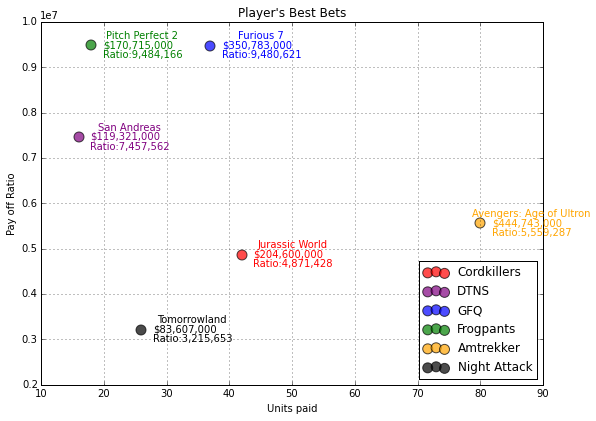

In [19]:
fig,ax = plt.subplots(figsize=(9,6.5))
for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    labels = []
    ratios = []
    for item in info[0]:
        labels.append(item[0])
        ratios.append(item[2]/item[1])
        x_axis.append(item[1])
        y_axis.append(item[2])
    BigWinner = ratios.index(max(ratios))
    
    plt.scatter(x_axis[BigWinner],ratios[BigWinner],s=100,alpha=0.7,label=player,c=colors[player])
    plt.annotate(movieName[labels[BigWinner]], (x_axis[BigWinner]+8,ratios[BigWinner]+100000),va="bottom", ha="center",color=colors[player])
    plt.annotate("$"+locale.format("%d", y_axis[BigWinner], grouping=True), (x_axis[BigWinner]+2,ratios[BigWinner]),va="center", ha="left",color=colors[player])
    plt.annotate("Ratio:"+locale.format("%d", ratios[BigWinner], grouping=True), (x_axis[BigWinner]+2,ratios[BigWinner]-200000),va="center", ha="left",color=colors[player])
        
ax.set_ylabel("Pay off Ratio")
ax.set_xlabel("Units paid")
plt.grid(True)
plt.title("Player's Best Bets")
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')
plt.show()

So this is a nice way to get more insight into how "smart" each player was in picking their movies but who made the most "smart" decissions or what were the best bets this season.

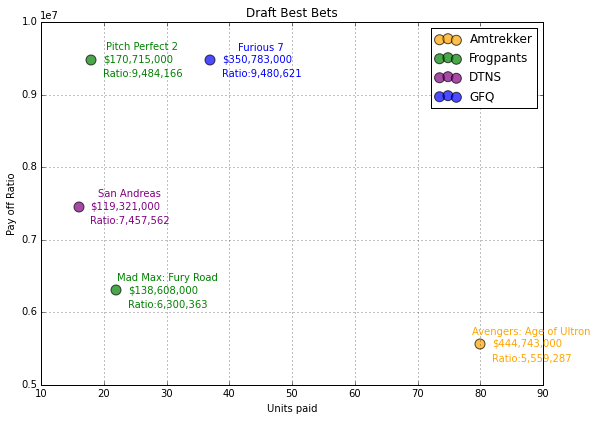

In [20]:
fig,ax = plt.subplots(figsize=(9,6.5))

x_axis = []
y_axis = []
labels = []
ratios = []
player_= []

for player,info in players.iteritems():
    for item in info[0]:
        labels.append(item[0])
        ratios.append(item[2]/item[1])
        x_axis.append(item[1])
        y_axis.append(item[2])
        player_.append(player)

topWinners = lambda x: sorted(range(len(ratios)), key=lambda i: ratios[i])[-x:]

for BigWinner in topWinners(5):
    plt.scatter(x_axis[BigWinner],ratios[BigWinner],s=100,alpha=0.7,label=player_[BigWinner],c=colors[player_[BigWinner]])
    
    plt.annotate(movieName[labels[BigWinner]], (x_axis[BigWinner]+8,ratios[BigWinner]+100000),va="bottom", ha="center",color=colors[player_[BigWinner]])
    plt.annotate("$"+locale.format("%d", y_axis[BigWinner], grouping=True), (x_axis[BigWinner]+2,ratios[BigWinner]),va="center", ha="left",color=colors[player_[BigWinner]])
    plt.annotate("Ratio:"+locale.format("%d", ratios[BigWinner], grouping=True), (x_axis[BigWinner]+2,ratios[BigWinner]-200000),va="center", ha="left",color=colors[player_[BigWinner]])
        
ax.set_ylabel("Pay off Ratio")
ax.set_xlabel("Units paid")
plt.grid(True)
plt.title("Draft Best Bets")
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
leg = plt.legend(handle_list, label_list)
leg.get_frame().set_facecolor('#FFFFFF')
plt.show()

So now we have a good gauge of what exactly makes a good bet. Can we somehow define progress as being under or over a certain value.

To do this, let's first calculate what a good average bet is from the top 5 betters. To do this, we'll calculate the average ratio for our ideal movie candidate.

In [21]:
candidate = np.average([ratios[w] for w in topWinners(5)])
print(candidate)

7656399.8


So now we know what a movie's ratio should be for it to be one of the best movies. Let's see who falls into that bracket with relation to all the movies bought this summer.

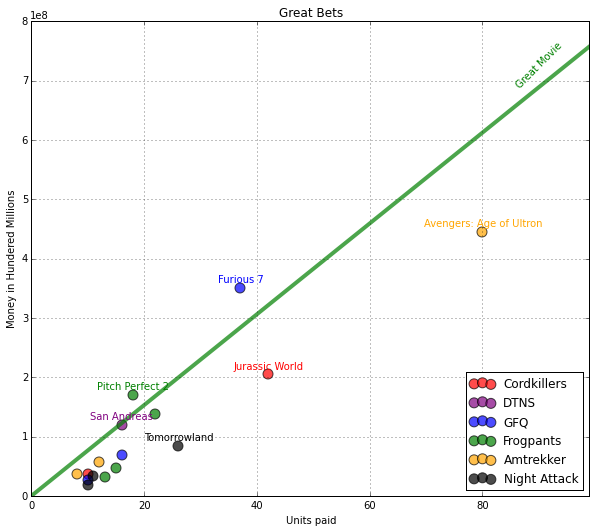

In [22]:
fig,ax = plt.subplots(figsize=(10,8.5))

xmax = -1
ymax = -1

x_ = []
y_ = []

bestGross = {
        "Cordkillers":[-1,-1,""],
        "DTNS":[-1,-1,""],
        "GFQ":[-1,-1,""],
        "Frogpants":[-1,-1,""],
        "Amtrekker":[-1,-1,""],
        "Night Attack":[-1,-1,""]
    }

for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    for item in info[0]:
        if(item[2] != 0):
            
            x_axis.append(item[1])
            x_.append(item[1])
            y_axis.append(item[2])
            y_.append(item[2])
        if item[2] > bestGross[player][1]:
            bestGross[player][1] = item[2]
            bestGross[player][0] = item[1]
            bestGross[player][2] = item[0]
            
        if (item[1] > xmax): 
            xmax = item[1]
        if (item[2] > ymax): 
            ymax = item[2]
    ax.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])


for player,info in bestGross.iteritems():
    ax.annotate(movieName[info[2]], (info[0],info[1]+6000000),va="bottom", ha="center",color=colors[player])

ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Units paid")
plt.title("Great Bets")
plt.grid(True)
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')

LX = np.arange(0,100,1)
LY = [candidate * lo for lo in LX]
plt.text(90,LY[-1]+10000000,"Great Movie",rotation=45,horizontalalignment="center",verticalalignment="top",color="green")
plt.plot(LX, LY,color="green",alpha=.7,linewidth=4)
    
a,b = plt.ylim()
plt.ylim(0,b)
plt.xlim(0,99)
plt.show()

So that gives us a good amount of insight about what it really takes to be a Great Movie. But that was just taking the top 5 ratios and seeing that line, let's see what are some other betting lines look like.

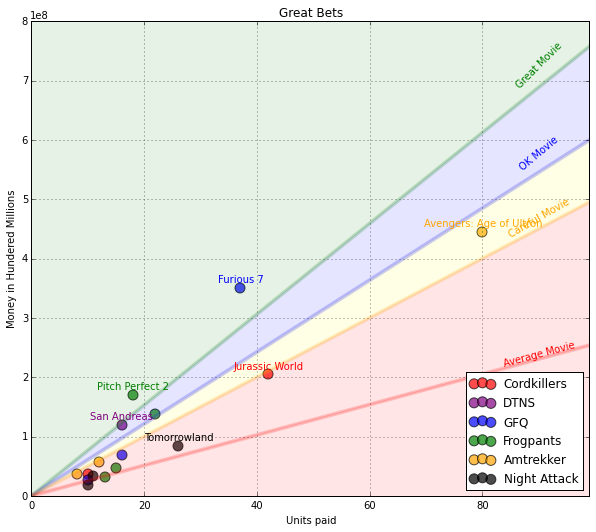

In [23]:
fig,ax = plt.subplots(figsize=(10,8.5))

xmax = -1
ymax = -1

x_ = []
y_ = []

bestGross = {
        "Cordkillers":[-1,-1,""],
        "DTNS":[-1,-1,""],
        "GFQ":[-1,-1,""],
        "Frogpants":[-1,-1,""],
        "Amtrekker":[-1,-1,""],
        "Night Attack":[-1,-1,""]
    }

for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    for item in info[0]:
        if(item[2] != 0):
            
            x_axis.append(item[1])
            x_.append(item[1])
            y_axis.append(item[2])
            y_.append(item[2])
        if item[2] > bestGross[player][1]:
            bestGross[player][1] = item[2]
            bestGross[player][0] = item[1]
            bestGross[player][2] = item[0]
            
        if (item[1] > xmax): 
            xmax = item[1]
        if (item[2] > ymax): 
            ymax = item[2]
    ax.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])


for player,info in bestGross.iteritems():
    ax.annotate(movieName[info[2]], (info[0],info[1]+6000000),va="bottom", ha="center",color=colors[player])

ax.set_ylabel("Money in Hundered Millions")
ax.set_xlabel("Units paid")
plt.title("Great Bets")
plt.grid(True)
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')

LX = np.arange(0,100,1)
LY = [candidate * lo for lo in LX]
MY = [np.average([ratios[w] for w in topWinners(10)]) * lo for lo in LX]
OY = [np.average([ratios[w] for w in topWinners(15)]) * lo for lo in LX]
BY = [np.average([ratios[w] for w in topWinners(len(movieName.keys()))]) * lo for lo in LX]

plt.text(90,LY[-1]+10000000,"Great Movie",rotation=45,horizontalalignment="center",verticalalignment="top",color="green")

plt.plot(LX, LY,color="green",alpha=.2,linewidth=4)

plt.text(90,MY[-1]+10000000,"OK Movie",rotation=40,horizontalalignment="center",verticalalignment="top",color="blue")
plt.plot(LX, MY,color="blue",alpha=.2,linewidth=4)

plt.text(90,OY[-1]+10000000,"Careful Movie",rotation=30,horizontalalignment="center",verticalalignment="top",color="orange")
plt.plot(LX, OY,color="orange",alpha=.2,linewidth=4)

plt.text(90,BY[-1]+10000000,"Average Movie",rotation=15,horizontalalignment="center",verticalalignment="top",color="red")
plt.plot(LX, BY,color="red",alpha=.2,linewidth=4)

a,b = plt.ylim()
plt.ylim(0,b)
plt.xlim(0,99)
plt.fill_between(LX,LY,b,color="green",alpha=.1)
plt.fill_between(LX,MY,LY,color="blue",alpha=.1)
plt.fill_between(LX,OY,MY,color="yellow",alpha=.1)
plt.fill_between(LX,BY,OY,color="red",alpha=.1)
plt.fill_between(LX,a,BY,color="red",alpha=.1)

plt.show()

So this is kinda interesting, we get to see what areas in the field would be considered good or bad, and where everyone seems to fall in line. It's a bit hard to tell where everything is though because our scale shows movie ratios with the colors but the scaling is maid for gross money. So let's rescale everything to see the ratios more well defined.

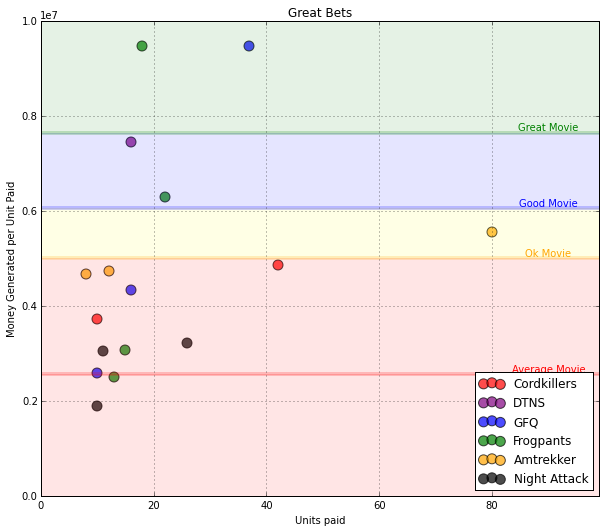

In [42]:
fig,ax = plt.subplots(figsize=(10,8.5))

xmax = -1
ymax = -1

x_ = []
y_ = []

bestGross = {
        "Cordkillers":[-1,-1,""],
        "DTNS":[-1,-1,""],
        "GFQ":[-1,-1,""],
        "Frogpants":[-1,-1,""],
        "Amtrekker":[-1,-1,""],
        "Night Attack":[-1,-1,""]
    }

for player,info in players.iteritems():
    x_axis = []
    y_axis = []
    for item in info[0]:
        if(item[2] != 0):
            
            x_axis.append(item[1])
            x_.append(item[1])
            y_axis.append(item[2]/item[1])
            y_.append(item[2])
        if item[2] > bestGross[player][1]:
            bestGross[player][1] = item[2]
            bestGross[player][0] = item[1]
            bestGross[player][2] = item[0]
            
        if (item[1] > xmax): 
            xmax = item[1]
        if (item[2] > ymax): 
            ymax = item[2]
    ax.scatter(x_axis,y_axis,s=100,alpha=0.7,label=player,c=colors[player])

ax.set_ylabel("Money Generated per Unit Paid")
ax.set_xlabel("Units paid")
plt.title("Great Bets")
plt.grid(True)
leg = plt.legend(loc=4)
leg.get_frame().set_facecolor('#FFFFFF')


LX = np.arange(0,100,1)
LY = [candidate + lo for lo in LX]
MY = [np.average([ratios[w] for w in topWinners(10)]) + lo for lo in LX]
OY = [np.average([ratios[w] for w in topWinners(15)]) + lo for lo in LX]
BY = [np.average([ratios[w] for w in topWinners(len(movieName.keys()))]) + lo for lo in LX]

plt.text(90,LY[-1],"Great Movie",horizontalalignment="center",verticalalignment="bottom",color="green")

plt.plot(LX, LY,color="green",alpha=.2,linewidth=4)

plt.text(90,MY[-1],"Good Movie",horizontalalignment="center",verticalalignment="bottom",color="blue")
plt.plot(LX, MY,color="blue",alpha=.2,linewidth=4)

plt.text(90,OY[-1],"Ok Movie",horizontalalignment="center",verticalalignment="bottom",color="orange")
plt.plot(LX, OY,color="orange",alpha=.2,linewidth=4)

plt.text(90,BY[-1],"Average Movie",horizontalalignment="center",verticalalignment="bottom",color="red")
plt.plot(LX, BY,color="red",alpha=.2,linewidth=4)

a,b = plt.ylim()
plt.ylim(0,b)
plt.xlim(0,99)
plt.fill_between(LX,LY,b,color="green",alpha=.1)
plt.fill_between(LX,MY,LY,color="blue",alpha=.1)
plt.fill_between(LX,OY,MY,color="yellow",alpha=.1)
plt.fill_between(LX,BY,OY,color="red",alpha=.1)
plt.fill_between(LX,0,BY,color="red",alpha=.1)

plt.show()

So that's kinda interesting how we can see that different perspectives and scalings will change how we see the data. So we have three vectors of information (cost in units, total gross, best ratio), let's plot it in a 3D graph.

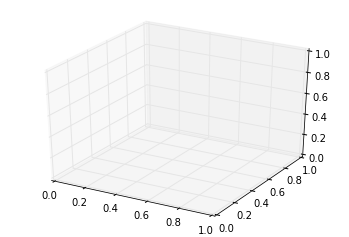

In [43]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

So that's really fun and interesting, but it still doesn't tell us much. There's so much data our there, let's see if we can use some more data aquisition to grab more.

#Data Aggregation Part 2

##Ratings and APIs